# Group testing with uncertainty

<p>Arnau Tibau-Puig, arnau dot tibau at gmail dot com, April 19th, 2020</p>
<p>The source code for this web page can be found in Github: <a href="https://github.com/atibaup/group-testing">github.com/atibaup/group-testing</a></p>

**Note**: This is part II of my blog post on ["Group testing for prevalence estimation and disease monitoring"](https://atibaup.github.io/group-testing/).

## Introduction

In my [previous post](https://atibaup.github.io/group-testing/), we discussed Dorfman's (2-stage) Group Testing strategy, whose setup can be quickly described by the following figure:

![Notation convention](simple_group_testing_setup.png)

Under that simplified setup, where we assumed that our test was **errorless** (that is, it generated no false negatives or false positives), we showed that one could obtain substantial efficiencies by applying the following 
group testing strategy:

1. Divide the population into groups of $g$ individuals
2. For each group, draw a specimen from each individual and pool them together.
3. Run the test on the pooled sample. If the test turns positive, test each of the $g$ individuals in the pool, running a total of $g+1$ tests for that pool. Otherwise, if the test turns negative, label the $g$ individuals as non-infected.

In particular, Dorfman showed that we could detect individuals infected with a low-prevalence disease with only a fraction of the tests needed to test individually the whole population. **For example, for a disease with a prevalence of 1%, we could identify the infected individuals by only running 1/5th of the tests necessary to test the whole population**. In other words, **if we have a limited number of tests, we could screen 5 times as many people**: 

![Notation convention](savings.png)

However, during the derivation of the above charts, we hid a couple of important details under the rug: 

1. we assumed that the testing procedure was errorless, and 
2. that the test results within and across groups were statistically independently.

In this post we relax the first assumption and consider the situation were the test procedure is noisy, under a pretty generic statistical model of test errors.

## Characterizing noisy tests

In the original Dorfman setup, it is implicitly assumed that there exist a methodology to, given a sample from an individual or a group of individuals, determine whether the sample contains the biomarker of interest, say, a syphilis antigen. This is what we call an errorless or noiseless test: a test that perfectly identifies the presence or absence of a given biomarker, without error.

In practice this is an unrealistic assumption: almost all tests that depend on measuring physical quantities are subject to (at least) measurement error, and hence they are not perfect. Luckily, modelling decision-making under uncertainty has been the bread and butter of statistics for almost 100 years. 

To characterize a test with error, we will need to define two additional quantities:
* a **test statistic**, which we will usually denote by a random variable $s$,
* a **decision threshold**, which we will denote by a deterministic value $\eta$.

The test statistic is typically a function of the quantity we measure. For example, in the Real Time-Polymerase Chain Reaction (RT-PCR) assays used to detect the presence of viral RNA in a sample, the test statistic is a function of the number of thermocycles needed for the fluorescence of a sample to exceed a given threshold. This statistic is a (non-linear) function of the underlying quantitiy of interest, which is the concentration of viral RNA.

Given an observation for the test statistic, $s$, we can then define the outcome of the test as a Bernouilli random variable $t$ defined as follows:

$t = \left\{\begin{array}{cc} 1 & s\geq \eta \\ 0 & \mbox{otherwise}\end{array}\right.$,

With this notation at hand, we are ready to characterize the statistical error that ensues from the fact that $s$ is a non-deterministic quantity. To do so, we typically define two quantities:

* The **Specificity**, which we will denote by $\pi_0$ and define as $\pi_0 = P\left(t = 0 | i = 0 \right)$, the probability of discarding an infection if the individual is healthy,

* The **Sensitivity**, which we will denote by $\pi_1$ and define as $\pi_1 = P\left(t = 1 | i = 1 \right)$, the probability of detecting an infection if the individual is infected.

Remember that in our setup $i$ denotes whether an individual is really infected or not, that is, the "ground truth". 

Note that our original errorless tests are a special case of this model, where both the sensitivity and the specificity are equal to $1$. That is the same as saying that there are no false negatives or false positives. On the other hand, when there is uncertainty, it is often impossible to achieve both perfect *sensitivity* and *specificity*. As we become more sensitive in detecting positives, increasing the *sensitivity*, we will have to accept a few false positives, that is, a decrease in *specificity*.

In order to better understand how these quantities evolve as a function of the amount of uncertainty, we plot below the behavior of these quantities as a function of $\eta$ and a specific instance of our model where $s | i \sim  \mathcal{N}\left(\mu_{i}, \sigma_q\right)$. As we can see, swapping over $\eta$ generates a curve of $\pi_0$ and $\pi_1$, also known as [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). The [Area Under the Curve (AUC)](https://en.wikipedia.org/wiki/Total_operating_characteristic#Area_under_the_curve) is a measure of how much error a test displays - the higher the variance the lower the Area Under the Curve.

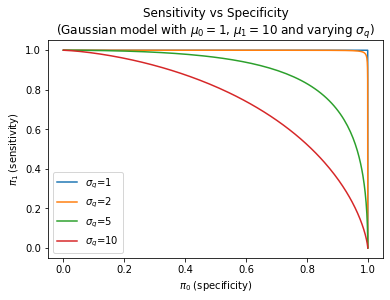

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as st

def specificity(eta, mu_0, sigma_q):
    return st.norm.cdf(eta, loc=mu_0, scale=sigma_q)

def sensitivity(eta, mu_1, sigma_q):
    return 1 - st.norm.cdf(eta, loc=mu_1, scale=sigma_q)

mu_0 = 1
mu_1 = 10
sigma_q_s = [1, 2, 5, 10]
eta_choices = np.linspace(-100, 100, 1000)

fig, axs = plt.subplots(1, 1)

for sigma_q in sigma_q_s:
    specificities = specificity(eta_choices, mu_0, sigma_q)
    sensitivities = sensitivity(eta_choices, mu_1, sigma_q)
    axs.plot(sensitivities, specificities, label=f'$\sigma_q$={sigma_q}')
    
axs.set_ylabel('$\pi_1$ (sensitivity)')
axs.set_xlabel('$\pi_0$ (specificity)')
plt.title('Sensitivity vs Specificity\n(Gaussian model with $\mu_0=1$, $\mu_1=10$ and varying $\sigma_q$)')
plt.legend()
plt.show()

## Group testing with uncertainty

Before we formalize the problem set up, it can be healthy to ask ourselves what do we expect to happen when we start using a noisy testing procedure with pooled samples... Would we expect the expected number of tests to increase or decrease? Do we expect the amount of false positives/negatives to be larger or smaller than the individual testing strategy?

At first sight, it's hard to imagine how errors could help in any way. But it's also easy to show that a noisy testing procedure could actually *reduce the expected number of tests, though at the expense of increasing the false negative rate*. To see this, consider the extreme case of a test with zero specificity, which always rejects all groups. We will only perform $\frac{N}{g}$ tests, but we will have a terrible false negative rate (we won't identify any infection!). This very simple line of reasoning seems to suggest that errors can increase or decrease both the number of tests we end up performing as well as the performance of our estimates.

Let's setup the problem now. We will need to expand the individual testing notation from the previous section and define:

* $\bar{i}_k$: a Bernouilli random variable denoting whether *anyone* in the group is infected or not, which we can analytically define as $\bar{i}_k = \max_{j \in \mathcal{G}_k} i_j$.
* $\bar{q}_k$: a real-valued random variable corresponding to the measurement of a bio-marker for the pooled sample corresponding to group $k$. In general, $\bar{q}_k$ will be a function of $q_j, j \in \mathcal{G}_k$.
* $\bar{s}_k$: the group test statistic, which we will assume to take the form $\bar{s}_k = f(\bar{q}_k, \epsilon)$ where $f$ is deterministic and $\epsilon$ is iid noise.
* $\bar{t}_k$: the group test outcome, a Bernouilli random variable defined as follows:

$\bar{t}_k= \left\{\begin{array}{cc} 1 & \bar{s}_k\geq \bar{\eta} \\ 0 & \mbox{otherwise}\end{array}\right.$,

where $\bar{\eta}$ is now the *group decision threshold*. Same as earlier, we can now characterize the statistical performance of one group test by defining its:

* **Group-Specificity**, which we will denote by $\bar{\pi}_0$ and define as  $\bar{\pi}_0 = P\left(\bar{t} = 0 | \bar{i}_k = 0 \right)$,

* **Group-Sensitivity**, which we will denote by $\bar{\pi}_1$ and define as  $\bar{\pi}_1 = P\left(\bar{t} = 0 | \bar{i}_k = 1\right)$

The following diagram can serve as a quick reference of the group testing setup and notation (compare to the diagram of Dorfman's original setup in the Introduction):

![Notation convention](noisy_group_testing_setup_v2.png)


### Impact of dilution on group-specificity and group-sensitivity 

The first question we want to study is how the specificity and sensitivity of the pooled test are impacted by the dilution of a "positive" (infected) sample in a pool of $g-1$ "healthy" samples. At first sight, it seems that diluting an infected sample shouldn't help its group-sensitivity... Consider the extreme case where the group is so big that the concentration of the infected biomarker becomes negligible and thus it is impossible to detect anything. 

In order to gain more understanding without resorting to computational tools, we will make a few additional simplifying assumptions:

1. We will assume that, conditional on the infection indicator, the biomarker measurements follow a Normal distribution $q_j | i_j \sim  \mathcal{N}\left(\mu_{i_j}, \sigma_q\right)$ parameterized by $\mu_0, \mu_1$ and $\sigma_q$.
2. We will also assume that the pooled biomarker measurement is equal to the average of biomarker measurements in the pool, that is $\bar{q}_k = \frac{1}{g}\sum_{j \in \mathcal{G}_k} q_j$
3. We will also assume that both the group and individual testing statistics, are defined by the following relation  $s = f\left(q\right)$ where $f$ is a monotonic function of its argument. 

Note that the last two assumptions seem reasonable: On one hand, if we are measuring concentrations of a given biomarker in a sample, when mixing the samples we would expect the resulting concentration to be the average of each member in the pool. On the other, a well-behaved test statistic should evolve montonically with the concentration of interest.

Under these additional assumptions we can define the **group-specificity** as:

$\bar{\pi}_0 = P\left(\bar{t} = 0 | \bar{i}_k = 0 \right) = P\left(\bar{s}_k < \bar{\eta} | \bar{i}_k = 0 \right) = P\left(f(\bar{q}_k) < \bar{\eta} | \bar{i}_k = 0 \right) = P\left(\bar{q}_k < f^{-1}\left(\bar{\eta}\right) | \bar{i}_k = 0 \right)$

Since the individuals in the group have been chosen uniformly at random, it is fair to expect the quantities 
$q_j, j \in \mathcal{G}_k$ to be independent of each other, which allows us to conclude that:

$\bar{q}_k | \bar{i}_k = 0 \sim \mathcal{N}\left(\mu_{0}, \frac{1}{\sqrt{g}}\sigma_q\right)$,

where we have used the property that the sum of two normally distributed random variables is normally distributed with mean and variance equal to the sum of means and variances of each summand, respectively. As a consequence, if we set the group-threshold at $\bar{\eta}$, we have:

$\bar{\pi}_0 =  P\left(\bar{q}_k  | \bar{i}_k = 0 \right) = P\left( q_j < f^{-1}\left(\bar{\eta}\right) | i_j = 0 \right) = \phi\left(\sqrt{g}\left(\frac{f^{-1}\left(\bar{\eta}\right) - \mu_0}{\sigma_q}\right)\right)$

where $\phi\left(x\right)$ is the cumulative distribution function of the Standard Normal. Note that in order to obtain the same group-specificity as the specificity of an individual test, we would need to set the group threshold such that:

$\sqrt{g}\left(\frac{f^{-1}\left(\bar{\eta}\right) - \mu_0}{\sigma_q}\right) = \frac{f^{-1}\left(\eta\right) - \mu_0}{\sigma_q}$

which means that in such case the group-threshold should be set at:

$\bar{\eta} = f\left(\frac{f^{-1}\left(\eta\right) - \mu_0}{\sqrt{g}} + \mu_0 \right)$

On the other hand, we define the **group-sensitivity** as:

$\bar{\pi}_1 = P\left(\bar{t} = 1 | \bar{i}_k = 1 \right) = P\left(\bar{s}_k \geq \bar{\eta} | \bar{i}_k = 1 \right) =  P\left(\bar{q}_k \geq f^{-1}\left(\bar{\eta}\right) | \bar{i}_k = 1 \right)$

This expression is trickier to evaluate because there are several combinations of $\left\{i_j, j \in \mathcal{G}_k\right\}$ that correspond to $\bar{i}_k = 1$. The good news is that, given the individual-to-individual independence of $q_j$, and letting $0 \leq m_k = \sum_{j\in \mathcal{G}_k} i_j \leq g$ denote the number of infected individuals in group $\mathcal{G}_k$, we can easily characterize $\bar{q}_k$ as:

$\bar{q}_k | m_k \sim \mathcal{N}\left(\mu\left(g, n\right), \frac{\sigma_q}{\sqrt{g}}\right)$

where, for convenience, we define:

$\mu\left(g, n\right) = \frac{1}{g}\left(\left(g - n\right)\mu_{0} + n \mu_{1}\right)$,

and we have again leveraged standard properties of independent Normal random variables.
On the other hand, since $\left\{i_j\right\}_{j\in \mathcal{G}_k}$ are iid, we also have that $m_k$ is a Binomial random variable:

$P\left(m_k = m\right) = {g \choose m} p^m\left(1 - p\right)^{g-m}$,

and hence:

$\bar{\pi}_1 = \sum_{m=1}^g P\left(\bar{q}_k \geq f^{-1}\left(\bar{\eta}\right) | \bar{i}_k = 1, m_k=m\right)P\left(m_k=m | m_k \geq 1\right) = \sum_{m=1}^g\phi\left(\sqrt{g}\left(\frac{f^{-1}\left(\bar{\eta}\right) - \mu\left(g, m\right)}{\sigma_q}\right)\right)P\left(m_k=m | m_k \geq 1\right)$

where:

$P\left(m_k=m | m_k \geq 1\right) = \frac{1}{1 - \left(1 - p\right)^{g}}{g \choose m} p^m\left(1 - p\right)^{g-m}$

Note that for small enough $p$, 

$P\left(m_k=1 | m_k \geq 1\right) \approx 1$

and $\bar{\pi}_1$ can be approximated as:



In what follows, we will characterize computationally the degradation of $\bar{\pi}_1$ as a function of $p$ and $g$, under the simplified model we have used throughout this section:

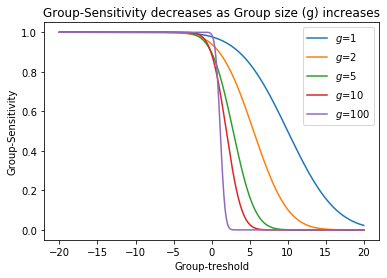

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as st

def group_sensitivity(eta, p, mu_0, mu_1, g, sigma_q):
    """
    Calculates $\bar{\pi}_1$ as described in the section above    
    """
    pi_0 = np.zeros(eta.shape)
    p_m_0 = st.binom.pmf(0, g, p, loc=0)
    for i in range(1, g+1):
        mu_i = 1./g*((g-i)*mu_0 + i*mu_1)
        p_m_given_m_l_1 = 1/(1-p_m_0)*st.binom.pmf(i, g, p, loc=0)
        p_t_given_m = 1 - st.norm.cdf(eta, loc=mu_i, scale=1/np.sqrt(g)*sigma_q)
        pi_0 += p_t_given_m*p_m_given_m_l_1
    return pi_0

mu_0 = 1
mu_1 = 10
sigma_q = 5
eta_choices = np.linspace(-20, 20, 1000)
group_sizes = [1, 2, 5, 10, 100]
p = 1e-2

fig, axs = plt.subplots(1, 1)

for group_size in group_sizes:
    sensitivities = group_sensitivity(eta_choices, p, mu_0, mu_1, group_size, sigma_q)
    axs.plot(eta_choices, sensitivities, label=f'$g$={group_size}')
    
axs.set_ylabel('Group-Sensitivity')
axs.set_xlabel('Group-treshold')
plt.title('Group-Sensitivity decreases as Group size (g) increases')
plt.legend()
plt.show()

The chart above shows that, under our simple model, sample dilution causes the group-sensitivity ($\bar{\pi}_1$) to deteriorate, for all $\eta$, as the group size increases. Interestingly enough, the amount of deterioration decreases as the group size increases.

### Impact of noise on the number of tests performed

We have reasoned earlier that noisy tests can both reduce or increase the number of tests we need to perform under Dorfman's two-stage procedure. Let's attempt now to characterize that quantity, as well as the savings relative to an individual testing strategy, when the tests have known group-sentitivity and group-specificity, denoted by $\bar{\pi}_1$ and $\bar{\pi}_0$.

Following the same reasoning we used in the [first post](https://atibaup.github.io/group-testing/), under an inter-group independence assumption, the expected number of tests performed is now given by:

$E\left(T'\right) = E\left(\sum_{n=1}^{N/g} I_{\bar{t}_n=1}\left(g + 1\right) + I_{\bar{t}_n=0} \right) = \frac{n}{g}\left(\left(1- P_0'\right)\left(g + 1\right) + P_0'\right)$

where we use $T'$ to indicate the number of tests necessary in the presence of test errors,
to differentiate it from the number of tests $T$ in the errorless setting, and where $P_0'$ denotes the probability of the group-test turning negative:

$P_0' = E\left(I_{\bar{t}_n=0}\right) = P\left(\bar{t}_n=0\right)$,

which under the presence of noise, is now a function of
$\bar{\pi}_1$ and $\bar{\pi}_0$:

$P_0' = P\left(\bar{t}_n=0 | \bar{i}_n = 0\right)P\left(\bar{i}_n = 0\right) + P\left(\bar{t}_n=0 | \bar{i}_n = 1\right)P\left(\bar{i}_n = 1\right) = \bar{\pi}_0 P_0 + \left(1 - \bar{\pi}_1\right)\left(1 - P_0\right)$

where we have let $P_0=P\left(\bar{i}_n = 0\right) = \left(1 - p\right)^g$ (provided again we have intra-group independence between the individuals). 

We can also define the savings relative to the individual testing strategy and calculate its expectation:

$E\left(\gamma'\right) = 1 - \frac{g + 1}{g}\left(1 - P_0'\right) - \frac{1}{g}P_0'$

Let's explore the dependency of $E\left(\gamma'\right)$ on $p$, $g$ and $\bar{\pi}_1$ and $\bar{\pi}_0$:

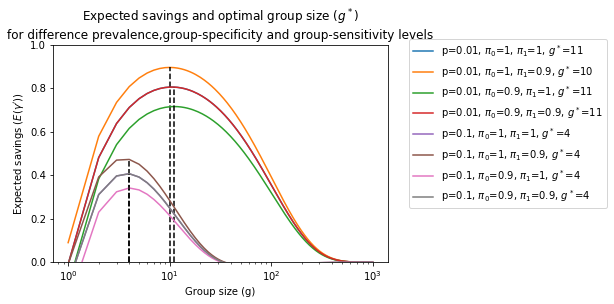

In [3]:
from matplotlib import pyplot as plt
import numpy as np

def expected_savings(p, group_size, pi_0, pi_1):
    p_i_0 = np.power(1 - p, group_size)
    p_z = pi_0*p_i_0 + (1-pi_1)*p_i_0
    p_nz = 1 - p_z
    savings = 1 - (group_size+1)/group_size * p_nz - 1/group_size*p_z
    return savings

p_choices = [1e-2, 1e-1]
pi_0_choices = [1.0, 0.9]
pi_1_choices = [1.0, 0.9]
g_values = np.arange(1, 1000, step=1)

for p in p_choices:
    for pi_0 in pi_0_choices:
        for pi_1 in pi_1_choices:
            savings = np.array([expected_savings(p, g, pi_0, pi_1) for g in g_values])
            opt_g = np.argmax(savings)
            plt.semilogx(
                g_values, savings, 
                label=f'p={p:.2g}, $\pi_0$={pi_0:.2g}, $\pi_1$={pi_1:.2g}, $g^*$={g_values[opt_g]}')
        plt.semilogx([g_values[opt_g], g_values[opt_g]], [0, savings[opt_g]], '--k')
    
plt.xlabel('Group size (g)')
plt.ylabel('Expected savings ($E(\gamma\')$)')
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('Expected savings and optimal group size ($g^*$)\nfor difference prevalence,'
          'group-specificity and group-sensitivity levels')
plt.show()

It is clear from the figure that the presence of noise can both increase or decrease the expected savings from applying a group-testing procedure. In general, decreasing the group-sensitivity ($\bar{\pi}_1$) will result in higher savings, as we will see next at the expense of a larger false negative rate. On the other hand, a decrease in the specificity will result in smaller savings, as well as a larger amount of false positives. Interestingly, when $\bar{\pi}_0=\bar{\pi}_1$ we have that 

$P_0' = \bar{\pi}_0 P_0 + \left(1 - \bar{\pi}_1\right)\left(1 - P_0\right) = P_0$

and hence, in this special case, the amount of savings and optimal group size is the same as in the noiseless case, $E\left(\gamma'\right)=E\left(\gamma\right)$.

### Global specificity and sensitivity

So far we have been able to characterize the group-sensitivity and group-specificity of the first stage in Dorfman's group test procedure. We have also used that characterization to understand the expected savings in number of tests ($E(\gamma')$) relative to an individual testing strategy, as well as the optimal group size in the presence of test noise.

We still haven't said anything yet about the **global, individual** sensitivity and specificity at the end of the 2-stage Dorfman group-testing procedure. To do so, we will need to introduce once again some additional notation: We will identify by $t'_j$ the test outcome for individual $j$ at the end of the second stage, as illustrated by the diagram below:

![Notation convention](notation_diagram.png)

As illustrated in the diagram above, according to Dorfman's procedure, an individual will test positive ($t'_j=1$) if both the first stage group-test for her group is positive ($\bar{t}_k=1$) and the second stage test is positive ($t_j=1$). Otherwise the individual will test negative:

$t'_j = \left\{ \begin{array}{cc} 1 & \mbox{ if } \bar{t}_k=1, t_j=1 \\ 0 & \mbox{ if } \bar{t}_k=0 \mbox{ or } \bar{t}_k=1, t_j=0\end{array}\right.$
    
This allows us to characterize the global specificity of the 2-stage procedure ($\pi_0'$) as:

$\pi_0' = P\left(t'_j=0 | i_j=0 \right) = P\left(t'_j=0 | i_j=0, \bar{t}_k=0 \right)P\left(\bar{t}_k=0 | i_j=0 \right) + P\left(t'_j=0 | i_j=0, \bar{t}_k=1 \right)P\left(\bar{t}_k=1 | i_j=0 \right)$

Looking at each term on the right hand side individually, we see that two of them can be explicitly calculated:

* $P\left(t'_j=0 | i_j=0, \bar{t}_k=0 \right) = 1$, because according to the procedure, the individual is automatically assumed to be a negative if the group-test turns negative,
* $P\left(t'_j=0 | i_j=0, \bar{t}_k=1 \right) = P\left(t'_j=0 | i_j=0\right) = \pi_0$ because the outcome of the second test is independent of $\bar{t}_k=1$, conditional on $i_j=0$,

Similarly, we can also characterize the global specificity of the 2-stage procedure ($\pi_1'$) as:

$\pi_1' = P\left(t'_j=1 | i_j=1 \right) = P\left(t'_j=1 | i_j=1, \bar{t}_k=0 \right)P\left(\bar{t}_k=0 | i_j=1 \right) + P\left(t'_j=1 | i_j=1, \bar{t}_k=1 \right)P\left(\bar{t}_k=1 | i_j=1 \right)$

where we can identify:

* $P\left(t'_j=1 | i_j=1, \bar{t}_k=0 \right)=0$,
* $P\left(t'_j=1 | i_j=1, \bar{t}_k=1 \right)=P\left(t'_j=1 | i_j=1 \right)=\pi_1$,

by construction of the second stage and conditional independence properties. 

### Global specificity and sensitivity in a simple Gaussian model

To get any further in characterizing $\pi_0'$ and $\pi_1'$, we would need specific models for the quantities $P\left(\bar{t}_k | i_j \right)$, appearing in $\pi_0'$ and $\pi_1'$. So let's explore what happens in the following special case:

1. The biomarker measurements follow a Normal distribution $q_j | i_j \sim  \mathcal{N}\left(\mu_{i_j}, \sigma_q\right)$ parameterized by $\mu_0, \mu_1$ and $\sigma_q$.
2. The pooled biomarker measurement is equal to the average of biomarker measurements in the pool, that is $\bar{q}_k = \frac{1}{g}\sum_{j \in \mathcal{G}_k} q_j$
3. The group and individual test statistics are defined by the following relation  $s = f\left(q\right)$ where $f$ is a monotonic function of its argument. 

First, we observe that we can characterize $P\left(\bar{t}_k | i_j \right)$ as:

$P\left(\bar{t}_k=x | i_j=y \right) = \sum_{n=0}^{g}P\left(\bar{t}_k=x | i_j=y, m_j=n \right)P\left(m_j=n| i_j=y\right)$

where we have defined an auxiliary random variable $m_j = \sum_{i\in \mathcal{G}_k \backslash j} i_i$ corresponding to the number of infected individuals in the same group as individual $j$, excluding $j$ itself. By virtue of the fact that the indivual infection indicators $i_j$ in a group are assumed to be statistically independent, we can see that:

$P\left(m_j=n| i_j\right) = P\left(m_j=n\right) = {g-1 \choose n} p^n\left(1 - p\right)^{g-1-n}$

where $p$ is the probability of any single individual being infected.

With this in hand, we now only need to worry about the $P\left(\bar{t}_k=x | i_j=y, m=n \right)$ piece. Using the model assumptions (1)-(3) above, we can see that:

$P\left(\bar{t} = 0 | i_j=x, m_j=n \right) = P\left(\bar{s}_k < \bar{\eta} | i_j=x, m_j=n \right) = P\left(f(\bar{q}_k) < \bar{\eta} | i_j=x, m_j=n\right) = P\left(\bar{q}_k < f^{-1}\left(\bar{\eta}\right) | i_j=x, m_j=n\right)$

and that we have

$\bar{q}_k | i_j, m_j=n \sim \mathcal{N}\left(\mu\left(i_j, n\right), \sigma_q\right)$

where 

$\mu\left(i_j=0, n\right) = \frac{1}{g}\left(\left(g - n\right)\mu_{0} + n \mu_{1}\right)$

and

$\mu\left(i_j=1, n\right) = \frac{1}{g}\left(\left(g - 1 - n\right)\mu_{0} + \left(n + 1\right)\mu_{1}\right)$

so in fact we can just compute $P\left(\bar{t} = 0 | i_j=x, m_j=n \right)$ from the Cumulative Distribution Function (cdf) of a Normal variable with mean given by the two expressions above. A similar result can be obtained for $P\left(\bar{t} = 1 | i_j=x, m_j=n \right)$ simply by reverting the inequality from $\bar{q}_k < f^{-1}\left(\bar{\eta}\right)$ to $\bar{q}_k \geq f^{-1}\left(\bar{\eta}\right)$. 

We are now ready to explore what the global sensitivity and specificity look like as a function of the group size, and
the test statistic thresholds $\eta$ and $\bar{\eta}$, which for simplicity we will set to $\bar{\eta} = \frac{1}{g}\eta$.

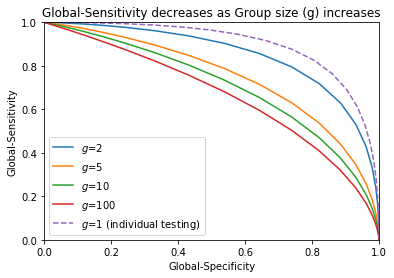

In [4]:
def individual_specificity(eta, mu_0, sigma_q):
    return st.norm.cdf(eta, loc=mu_0, scale=sigma_q)

def individual_sensitivity(eta, mu_1, sigma_q):
    return 1 - st.norm.cdf(eta, loc=mu_1, scale=sigma_q)

def mu(m, i, mu_0, mu_1, g):
    mu_ = 1./g*((g - 1 - m)*mu_0 + m*mu_1)
    if i == 0:
        mu_ += 1./g*mu_0
    else:
        mu_ += 1./g*mu_1
    return mu_

def proba_pooled_test_positive_given_i(mu_0, mu_1, sigma_q, group_eta, i, g, p):
    """
    Calculates P(\bar{t} = 1 | m_j, i) as detailed in the previous section 
    """
    pr = np.zeros(group_eta.shape)
    for m in range(g):
        p_m = st.binom.pmf(m, g - 1, p, loc=0)
        mu_j = mu(m, i, mu_0, mu_1, g)
        p_t_positive_given_i_and_m = 1 - st.norm.cdf(group_eta, loc=mu_j, scale=sigma_q)
        pr += p_t_positive_given_i_and_m*p_m
    return pr

def proba_pooled_test_negative_given_i(mu_0, mu_1, sigma_q, group_eta, i, g, p):
    """
    Calculates P(\bar{t} = 0 | m_j, i) as detailed in the previous section 
    """
    pr = np.zeros(group_eta.shape)
    for m in range(g):
        p_m = st.binom.pmf(m, g - 1, p, loc=0)
        mu_j = mu(m, i, mu_0, mu_1, g)
        p_t_negative_given_i_and_m = st.norm.cdf(group_eta, loc=mu_j, scale=sigma_q)
        pr += p_t_negative_given_i_and_m*p_m
    return pr

def global_specificity(eta, mu_0, mu_1, sigma_q, g, p, group_eta_factor=1):
    """
    $\pi_0' = P\left(\bar{t}_k=0 | i_j=0 \right) + \pi_0 P\left(\bar{t}_k=1 | i_j=0 \right)$
    
    where \pi_0 is the individual-test specificity at \eta
    
    and P\left(\bar{t}_k | i_j=0 \right) is computed at \bar{\eta} = eta * group_eta_factor
    """
    pi_0 = individual_specificity(eta, mu_0, sigma_q)
    group_eta = eta * group_eta_factor
    return proba_pooled_test_negative_given_i(mu_0, mu_1, sigma_q, group_eta, 0, g, p) + \
            pi_0 * proba_pooled_test_positive_given_i(mu_0, mu_1, sigma_q, group_eta, 0, g, p)

def global_sensitivity(eta, mu_0, mu_1, sigma_q, g, p, group_eta_factor=1):
    """
    $\pi_1' = \pi_1 P\left(\bar{t}_k=1 | i_j=1 \right)$
    
    where \pi_1 is the individual-test sensitivity at \eta
    
    and P\left(\bar{t}_k=1 | i_j=1 \right) is computed at \bar{\eta} = eta * group_eta_factor
    """
    pi_1 = individual_sensitivity(eta, mu_1, sigma_q)
    group_eta = eta * group_eta_factor
    return pi_1 * proba_pooled_test_positive_given_i(mu_0, mu_1, sigma_q, group_eta, 1, g, p)


mu_0 = 1
mu_1 = 10
sigma_q = 5
eta_choices = np.linspace(-1000, 100, 1000)
group_sizes = [2, 5, 10, 100]
p = 1e-2

fig, axs = plt.subplots(1, 1)
for group_size in group_sizes:
    sensitivities = global_sensitivity(eta_choices, mu_0, mu_1, sigma_q, group_size, p)
    specificities = global_specificity(eta_choices, mu_0, mu_1, sigma_q, group_size, p)
    axs.plot(specificities, sensitivities, label=f'$g$={group_size}')
    
axs.plot(
    individual_specificity(eta_choices, mu_0, sigma_q), 
    individual_sensitivity(eta_choices, mu_1, sigma_q), 
    '--',
    label=f'$g$=1 (individual testing)')

axs.set_ylabel('Global-Sensitivity')
axs.set_xlabel('Global-Specificity')
axs.set_ylim([0, 1])
axs.set_xlim([0, 1])
plt.title('Global-Sensitivity decreases as Group size (g) increases')
plt.legend()
plt.show()

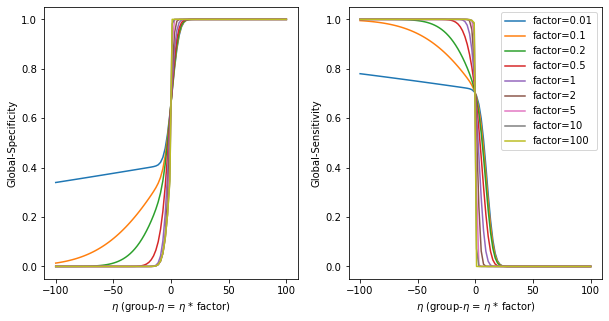

In [5]:
group_size = 5
mu_0 = 1
mu_1 = 10
sigma_q = 5
eta_choices = np.linspace(-100, 100, 100)
p = 0.01

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for factor in [1/100, 1/10, 1/5, 1/2, 1, 2, 5, 10, 100]:
    sensitivities = global_sensitivity(eta_choices, mu_0, mu_1, sigma_q, group_size, p, factor)
    specificities = global_specificity(eta_choices, mu_0, mu_1, sigma_q, group_size, p, factor)
    axs[0].plot(eta_choices, specificities, label=f'factor={factor}')
    axs[1].plot(eta_choices, sensitivities, label=f'factor={factor}')

axs[0].set_ylabel('Global-Specificity')
axs[0].set_xlabel('$\eta$ (group-$\eta$ = $\eta$ * factor)')
axs[1].set_ylabel('Global-Sensitivity')
axs[1].set_xlabel('$\eta$ (group-$\eta$ = $\eta$ * factor)')
plt.legend()
plt.show()

## Conclusions

* Mmmmm....